In [11]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import warnings
warnings.filterwarnings('ignore')



In [12]:
# Define the DeepfakeDetector model (same as in training)
class DeepfakeDetector(nn.Module):
    def __init__(self, pretrained=True):
        super(DeepfakeDetector, self).__init__()
        # Using the smaller EfficientNet-B0 as my training device does not have enough VRAM
        if pretrained:
            self.efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        else:
            self.efficientnet = efficientnet_b0(weights=None)

        #get feature extractor part of the pretrained model
        self.features = self.efficientnet.features
        
        #modified classifier head since the pretrained one was used to predict 1000 classes
        in_features = self.efficientnet.classifier[1].in_features
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1) #here we use only 1 output neuron because it was enough for binary classificaition, also it fit with the BCELoss later
        )
        # Replace the original classifier - because it was supposed to used in image classification
        self.efficientnet.classifier = self.classifier

    def forward(self, x):
        x = self.features(x)
        x = self.efficientnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def freeze_features(self):
        """Freezes the weights of the feature extractor."""
        print("Freezing feature extractor layers...")
        for param in self.features.parameters():
            param.requires_grad = False

    def unfreeze_features(self):
        """Unfreezes the weights of the feature extractor."""
        print("Unfreezing all layers...")
        for param in self.parameters():
            param.requires_grad = True

In [13]:
def get_sample_video(data_dir='video_detection_dataset', class_type='both'):
    """
    Get a random sample video from the dataset
    
    Args:
        data_dir: Path to the video dataset
        class_type: 'real', 'fake', or 'both' to specify which type of video to sample
    
    Returns:
        tuple: (video_path, label, class_name)
    """
    
    folder_to_class = {
        'DFD_original_sequences': (0, 'Real'),
        'DFD_manipulated_sequences': (1, 'Fake')
    }
    
    available_folders = list(folder_to_class.keys())
    
    if class_type == 'real':
        available_folders = ['DFD_original_sequences']
    elif class_type == 'fake':
        available_folders = ['DFD_manipulated_sequences']
    
    # Randomly select a folder (manipulated or original)
    selected_folder = random.choice(available_folders)
    folder_path = os.path.join(data_dir, selected_folder)
    
    # Get all video files in the folder
    video_files = [f for f in os.listdir(folder_path) if f.endswith('.mp4')]
    
    if not video_files:
        raise ValueError(f"No video files found in {folder_path}")
    
    #random select a video
    selected_video = random.choice(video_files)
    video_path = os.path.join(folder_path, selected_video)
    
    label, class_name = folder_to_class[selected_folder]
    
    return video_path, label, class_name

In [14]:
def extract_frames(video_path, num_frames=16):
    
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames == 0:
        cap.release()
        raise ValueError(f"Could not read frames from {video_path}")
    
    print(f"Total frames in video: {total_frames}")
    
    # Select frame indices randomly
    frame_indices = sorted(random.sample(range(total_frames), min(num_frames, total_frames)))
    print(f"Selected frame indices: {frame_indices}")
    
    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            # Convert BGR (OpenCV format) to RGB (to fit the matplotlib format)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
    
    cap.release()
    
    print(f"Successfully extracted {len(frames)} frames")
    return frames

In [15]:
def plot_frames(frames, title="Extracted Video Frames"):
    
    n_frames = len(frames)
    cols = 4
    rows = (n_frames + cols - 1) // cols 
    
    plt.figure(figsize=(16, 4 * rows))
    plt.suptitle(title, fontsize=16, fontweight='bold')
    
    for i, frame in enumerate(frames):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(frame)
        plt.title(f'Frame {i + 1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [16]:
def load_model(model_path='deepfake_detector_best.pth', device='cuda'):
    
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    print(f"Loading model on device: {device}")
    model = DeepfakeDetector(pretrained=False) 
    
    #Load the trained weights
    if os.path.exists(model_path):
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        print(f"Model weights loaded from {model_path}")
    else:
        print(f"Warning: Model file {model_path} not found. Using randomly initialized weights.")
    
    model.to(device)
    model.eval()  
    return model, device

In [17]:
def preprocess_frames(frames):
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    processed_frames = []
    for frame in frames:
        processed_frame = transform(frame)
        processed_frames.append(processed_frame)
    
    # Stack frames into a tensor
    frames_tensor = torch.stack(processed_frames)
    
    return frames_tensor

In [18]:
def infer_video(model, frames, device):
    model.eval()
    
    with torch.no_grad():
        
        frames = frames.to(device)
        outputs = model(frames)  #Shape: (num_frames, 1)
        
        # Average predictions across all frames
        avg_output = outputs.mean(dim=0)  # Shape: (1,)
        probability = torch.sigmoid(avg_output).item()
        predicted_class = 1 if probability > 0.5 else 0
        
        
        confidence = abs(probability - 0.5) * 2
    return probability, predicted_class, confidence

In [19]:
def run_demo(class_type='both'):
    
    video_path, true_label, true_class = get_sample_video(class_type=class_type)
    print(f"Selected video: {os.path.basename(video_path)}")
    print(f"Ground truth: {true_class}")
    
    frames = extract_frames(video_path, num_frames=16)
    plot_title = f"Frames from Video: {os.path.basename(video_path)}"
    plot_frames(frames, title=plot_title)
    
    model, device = load_model()
    
 
    processed_frames = preprocess_frames(frames)
    print(f"Processed frames shape: {processed_frames.shape}")
    
    probability, predicted_class, confidence = infer_video(model, processed_frames, device)
    

    print("\n" + "-" * 60)
    print("RESULTS")
    print(f"Video: {os.path.basename(video_path)}")
    print(f"Ground Truth: {true_class}")
    
    predicted_class_name = "Fake" if predicted_class == 1 else "Real"
    print(f"Model Prediction: {predicted_class_name}")
    print(f"Confidence: {confidence:.3f}")
    print(f"Fake Probability: {probability:.3f}")
    
    
    
    return {
        'video_path': video_path,
        'true_label': true_label,
        'true_class': true_class,
        'predicted_class': predicted_class,
        'predicted_class_name': predicted_class_name,
        'probability': probability,
        'confidence': confidence,
    }

Selected video: 14_26__kitchen_pan__SU8SAHTT.mp4
Ground truth: Fake (Label: 1)
Total frames in video: 618
Selected frame indices: [1, 71, 91, 107, 168, 185, 210, 229, 250, 263, 301, 340, 376, 411, 479, 564]
Successfully extracted 16 frames


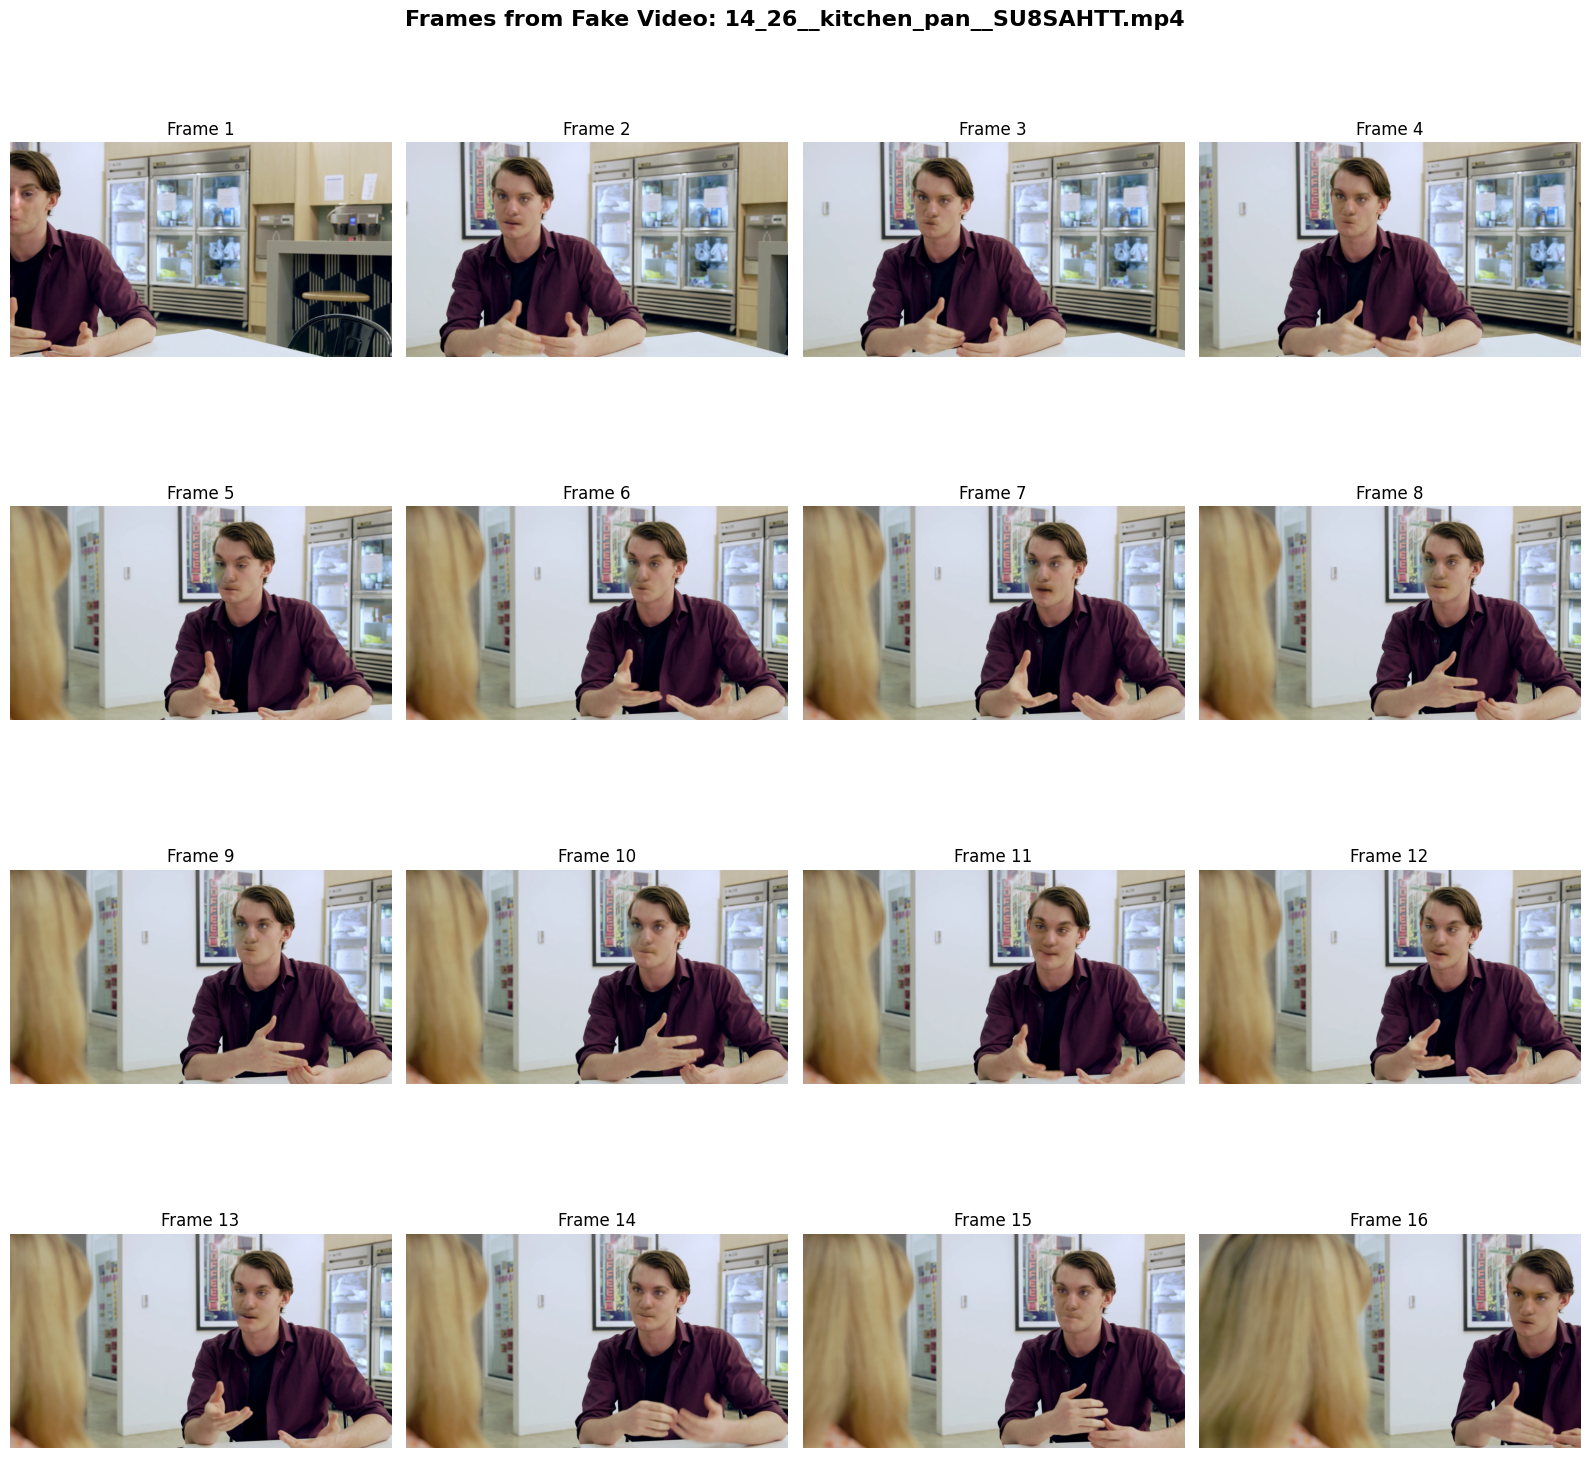

Loading model on device: cuda
Model weights loaded from deepfake_detector_best.pth
Processed frames shape: torch.Size([16, 3, 224, 224])

------------------------------------------------------------
RESULTS
Video: 14_26__kitchen_pan__SU8SAHTT.mp4
Ground Truth: Fake
Model Prediction: Fake
Confidence: 0.806
Fake Probability: 0.903


In [20]:
result = run_demo(class_type='both')